<a href="https://colab.research.google.com/github/N3wBaz/ml-intro/blob/main/7_trees_and_ensembles/rf_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
RANDOM_STATE = 2020

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
#Это для подключения tests в colab
!cp /content/gdrive/MyDrive/RS_school_course/7_trees_and_ensembles/tests.py /content

In [5]:
import tests

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [6]:
PATH = '/content/gdrive/MyDrive/RS_school_course/7_trees_and_ensembles/data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=RANDOM_STATE)

# Homework part 1. Implementation of Random Forest Classifier.

## Splitting criteria

**Task 1 - 2 points.** In this section you should implement two criteria for splitting of the feature space. Any of these can be used in the model.

### Gini index

0.5 points for *gini_index* function

In [8]:
from collections import Counter

def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """ 
    if len(x) == 0:
        return 0
    count = Counter(x)
    prob = np.asarray([*count.values()]) / len(x)   
    return 1 - np.sum(prob ** 2)

In [9]:
tests.test_gini_index(gini_index)

 All good!


0.5 points for *gini_gain* function

In [10]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """ 
    gain = gini_index(parent_node)  
    for split in splits:
        gain -= gini_index(split) * len(split) / len(parent_node)
    return gain



In [11]:
tests.test_gini_gain(gini_gain)

 All good!


### Entropy

0.5 points for *entropy* function. WARNING! Use only natural logarithm np.log() for calculation.

In [12]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    # If you use vectorized operations on a vector of frequencies p
    # where some of the relative frequencies may be 0, and you need to evaluate
    # the expression p * np.log(p), you can use the "where" argument of the np.log() function.
    # This will leave those elements of the array untouched by the function, 
    # thus evaluating x*log(x) as zero, exactly as we want it to be.

    count = Counter(x)
    prob = np.asarray([*count.values()]) / len(x)   

    return -np.sum(prob * np.log(prob, where=0<prob, out=np.ones(prob.shape)))

In [13]:
tests.test_entropy(entropy)

 All good!


0.5 points for *information_gain* function

In [14]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    info_gain = entropy(parent_node)
    for split in splits:
        info_gain -= entropy(split)* len(split) / len(parent_node)

    return info_gain

In [15]:
tests.test_information_gain(information_gain)

 All good!


## Split function

**Task 2 - 1 point** Implement *split_dataset* function. <br>
The rows of the dataframe received by a tree node are split into two dataframes depending on their values in a selected column. Rows with values smaller than the chosen threshold are stored in the resulting left dataframe, and we save rows with values larger than the threshold in the right dataframe. The array with target values should be split in accordance with the feature dataframe.

In [16]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """     
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value

    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]

    return left_X, right_X, left_y, right_y

In [17]:
tests.test_split_dataset(split_dataset)

 All good!


## Decision tree

**Task 3 - 4.5 points** In the Tree class below you need to complete the *fit(), predict_row()* and *predict()* functions.<br>
Each tree is basically a tree node that may have a left and a right child that are also trees. If a tree doesn't have any child nodes, we call it a leaf.<br>
Since features for splitting a dataframe are chosen randomly, we need a mechanism to control this randomness to aquire reproducibility for testing purposes. In our case we use the [Random Generator](https://numpy.org/doc/stable/reference/random/generator.html)<br>
By creation of a tree only the **criterion** and the **rng** fields are not filled with Nones, so each tree knows what criterion for dataframe splitting it should use. Each fitted tree knows as well by which column and value the split should be performed. If a tree is a leaf it doesn't have information about the split, but stores the predicted value.

In [18]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """
    def __init__(self, criterion='gini', random_gen=None):
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        self.threshold = None           # value of the next split
        self.column_index = None        # column to use for the next split
        self.outcome_probs = None       # the predicted value if the tree is a leaf
        self.left_child = None
        self.right_child = None
        self.random_gen = random_gen if random_gen is not None else np.random.default_rng(RANDOM_STATE)

    @property
    def is_terminal(self):
        """Define is it terminal node."""          
        return not bool(self.left_child and self.right_child)
    
    def _compute_gain(self, y, splits):
        """Compute split gain according to chosen criteria."""
        func = gini_gain if self.criterion == 'gini' else information_gain
        return func(y, splits)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""
        # Sample random subset of features
        subset = self.random_gen.choice(list(range(0, X.shape[1])), n_features, replace=False)

        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self._compute_gain(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain
    
    def _compute_outcome(self, y):
        """Save outcome probabilities for the leaf."""
        self.outcome_probs = np.around(np.sum(y) / y.shape[0])

    def fit(self, X, y, feature_frac=1.0, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array):      The training input samples. 2-dimensional numpy array.
            y (numpy-array):      The target values. 1-dimensional numpy array.
            feature_frac (float): The fraction of features to use when fit is performed. Must be 
                                  between 0.0 and 1.0 (default: 1.0, i.e. all features).
            max_depth (int):      The maximum depth of the tree. If None, then nodes are expanded
                                  until all leaves are pure.
        """
        # 3 points

        # Make this tree a leaf and return if max_depth doesn't allow it to grow further
        if max_depth is not None and max_depth <= 0:
            return self._compute_outcome(y)       

        if not 0.0 <= feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
        # Compute the number of features to use. Should be integer number
        n_features = int(X.shape[1] * feature_frac)

        
        # Find the next split    
        column, value, gain = self._find_best_split(X, y, n_features)
        
        # Make this tree a leaf and return if the split doesn't bring any gain
        if gain is None or gain == 0:
            self._compute_outcome(y)
            return None
        
        # Save the necessary information about the next split
        self.column_index = column
    
        self.threshold = value

        # Reduce the max_depth parameter for the next tree
    
        if max_depth is not None:
            max_depth -= 1

        # Split dataset
        left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

        # Grow left and right child. Pass over the parent's random generator
        # for reproducible results 
        self.left_child = Tree(criterion=self.criterion, random_gen=self.random_gen)
        self.left_child.fit(left_X, left_target, feature_frac,  max_depth)

        self.right_child = Tree(criterion=self.criterion, random_gen=self.random_gen)
        self.right_child.fit(right_X, right_target, feature_frac=feature_frac, max_depth=max_depth)

    def predict_row(self, row):
        """Predict single row."""
        # 0.5 points

        if not self.is_terminal:
            # Use the stored information about the split to define 
            # if the right or the left child to use
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        Returns:
            1-dimensional numpy-array with predictions     
        """ 
        # 1 point
        
        # Create a numpy array of zeros of necessary length to save predictions
        result = np.zeros(X.shape[0])
        # Go through all rows of the dataset
        for i in range(X.shape[0]):
            # Save the prediction for the current row
            result[i] = self.predict_row(X[i,:])
        return result

In [19]:
tests.test_tree(Tree)

 All good!


**Task 4 - 1 point** Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. **Explain** the results.

In [20]:
tree1 = Tree()
tree1.fit(np.asarray(X_train), np.asarray(y_train), max_depth=None)

In [21]:
tree2 = Tree()
tree2.fit(np.asarray(X_train), np.asarray(y_train), max_depth=3)

In [22]:
acc1 = accuracy_score(y_test, tree1.predict(np.asarray(X_test)))
acc2 = accuracy_score(y_test, tree2.predict(np.asarray(X_test)))
print("Точность с max_depth=None :  ", acc1)
print("Точность с max_depth=3 :  ", acc2)

Точность с max_depth=None :   0.6428571428571429
Точность с max_depth=3 :   0.6666666666666666


Доля верных ответов с выше с глубиной дерева 3, чем без ограничений. Это связано с тем, что процесс деления может продолжаться до тех пор, пока дерево не будет глубоким с большим количеством листьев, в которых будут абсолютно «чистые» подмножества содержащие примеры одного класса. Возможен вариант построения, в котором для каждого примера будет свой лист и следовательно свой уникальный путь ветвления. Такое дерево является переобученным.

In [23]:
def plot_metrics_on_depths(criterion='gini'):
    max_depths, train_scores, test_scores = [], [], []
    for max_depth in range(0, 10):
        max_depths.append(max_depth)
        model = Tree(criterion=criterion)
        model.fit(X_train.values, y_train.values, max_depth=max_depth)
        train_scores.append(accuracy_score(y_train, model.predict(X_train.values)))
        y_pred = model.predict(X_test.values)
        test_scores.append(accuracy_score(y_test, y_pred))
    res_metrics = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=max_depths)
    sns.set(rc={'figure.figsize':(16, 7)})
    plt.plot(res_metrics['train'], label='train score')
    plt.plot(res_metrics['test'], label='test score')
    plt.axvline(np.argmax(res_metrics['test']), color='C1', lw=10, alpha=0.2)
    plt.grid(True)
    plt.title("Accuracy as a function of max_depth")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show();

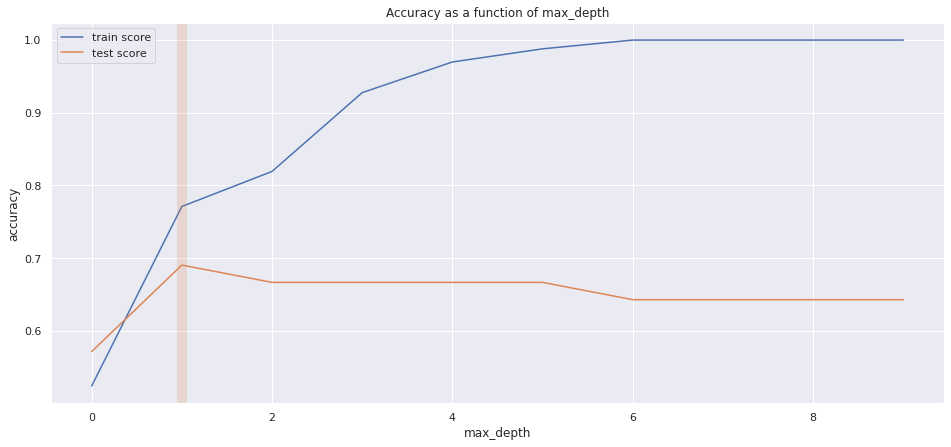

In [24]:
plot_metrics_on_depths('gini')

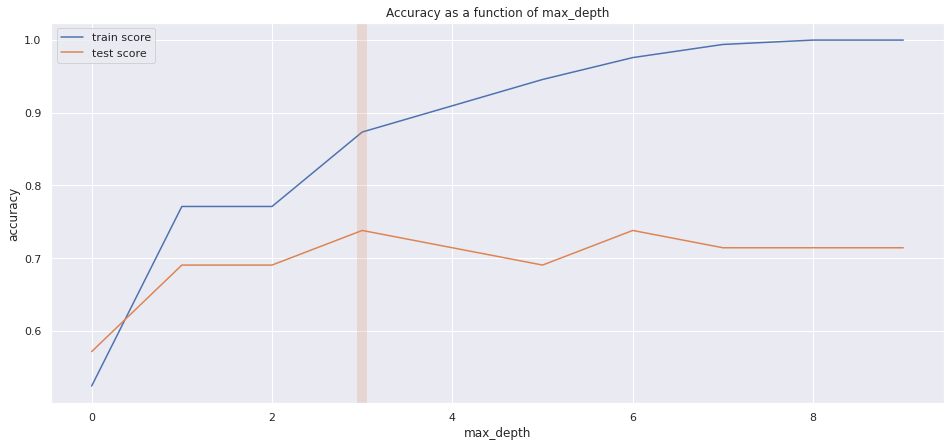

In [25]:
plot_metrics_on_depths('entropy')

Построены графики зависимости доли верных ответов от глубины дерева. Точность на тестовой выборке перестает расти при увеличении глубины дерева. В нашем конкретном случае для деления по критерию Джини глубина составляет - 1, а для энтропии глубина - 3. При дальнейшем росте глубины или начинает падать или колеблется около полученного значения. Происходит переобучение, так как доля верных ответов на тренировочных данных продолжает возрастать. Для борьбы с переобучением деревьев используются слудующие методы:


*   Ограничение глубины дерева.
*   Значение минимально допустимого числа примеров в узле
*   Так же остановка по достижению заданного критерия.(например, процентная доля правильно распознанных примеров)



## Random forest

**Task 5 - 1.5 Points** In the RandomForestClassifier class below you need to complete the *fit* and *predict()* functions

In [26]:
from sklearn.base import BaseEstimator

class RandomForestClassifier(BaseEstimator):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        feature_frac : float, default=None
            The fraction of features to use when looking for the best split. Must be 
            between 0.0 and 1.0. If None, then `feature_frac = 1 / sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        random_gen: numpy Random Generator object, default=None
            Generator should be passed over for reproducible results. If None, 
            a new np.random.default_rng() will be created.
    """

    def __init__(self, n_estimators=10, max_depth=None, feature_frac=None, 
                 criterion="entropy", bootstrap=True, random_gen=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        self.feature_frac = feature_frac
        
        if criterion not in ["gini", "entropy"]:
            raise ValueError(f'Unknown criteria for splits {criterion}')
        self.criterion = criterion
        
        self.random_gen = random_gen if random_gen is not None else np.random.default_rng(RANDOM_STATE)
        self.trees = [Tree(criterion=self.criterion, random_gen=self.random_gen) 
                            for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return self.random_gen.integers(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """
        # 0.5 points
        
        if self.feature_frac is None:
            self.feature_frac = 1 / np.sqrt(X.shape[1])
        elif not 0.0 <= self.feature_frac <= 1.0:
            raise ValueError('feature_frac must lie between 0.0 and 1.0')
            
        self._init_data(X, y)
        
        # Iterate over all trees in the forest
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            # Fit the tree    
            tree.fit(X, y, feature_frac=self.feature_frac  ,max_depth=self.max_depth)
            
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """
        # 1 point
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            # Create a numpy array of zeros of necessary length
            predictions = np.zeros(X.shape[0])
            # Go through all rows of the dataset
            for i in range(X.shape[0]):

                # Initialize a counter for voting
                row_pred = []

                # Sum up predictions from all the voters
                for tree in self.trees:
                    row_pred.append(tree.predict_row(X[i]))

                # Compute the mean of the votes    
                row_pred = np.mean(row_pred)

        #         # # Save the rounded value as the prediction for the current row
                predictions[i] = np.round(row_pred, 0)

            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [27]:
tests.test_random_forest(RandomForestClassifier)

 All good!


**Task 6 - 1 Point** Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. **Explain** the results.

In [28]:
forest_10 = RandomForestClassifier(n_estimators=10)
forest_100 = RandomForestClassifier(n_estimators=100)

In [29]:
forest_10.fit(X_train, y_train)
forest_100.fit(X_train, y_train)

In [30]:
acc10 = accuracy_score(y_test, forest_10.predict(np.asarray(X_test)))
acc100 = accuracy_score(y_test, forest_100.predict(np.asarray(X_test)))
print("Точность с 10 деревьями :  ", acc10)
print("Точность со 100 дереьями :  ", acc100)

Точность с 10 деревьями :   0.7380952380952381
Точность со 100 дереьями :   0.8571428571428571



 "Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784).Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных. Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных." [источник](https://habr.com/ru/company/ods/blog/324402/#:~:text=%D0%A5%D0%BE%D1%80%D0%BE%D1%88%D0%B8%D0%BC%20%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BE%D0%BC%20%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B9,%D1%83%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC%20%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D0%BF%D1%80%D0%B8%D1%81%D1%8F%D0%B6%D0%BD%D1%8B%D1%85.)

 В нашем случае в роли жюри приясяжных выступает совокупность деревьев, каждое из которых классифицирует независимо от остальных.

 Из полученых данных видно, что доля правильных ответов для случайного леса с 10 деревьями ниже, чем со 100 деревьями. Прогноз, предлагаемый большинством деревьев, принимается как окончательный.  Случайный лес усредняет ответы алгоритмов классификации (деревья), уменьшает дисперсию ошибки и уменьшает эффект переобучения. Используется бутстрап и бэггинг.


*Бэггинг* - идея классификации, где классификаторы компенсируют ошибки друг друга при голосовании. Классификаторы должны быть обучены на независимых наборах данных.
Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение.  [источник](https://habr.com/ru/company/ods/blog/324402/#:~:text=%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3%20%D0%BF%D0%BE%D0%B7%D0%B2%D0%BE%D0%BB%D1%8F%D0%B5%D1%82%20%D1%81%D0%BD%D0%B8%D0%B7%D0%B8%D1%82%D1%8C%20%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D1%8E%20(variance)%20%D0%BE%D0%B1%D1%83%D1%87%D0%B0%D0%B5%D0%BC%D0%BE%D0%B3%D0%BE%20%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80%D0%B0%2C%20%D1%83%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B0%D1%8F%20%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D1%83%2C%20%D0%BD%D0%B0%20%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%BA%D0%BE%20%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B0%20%D0%B1%D1%83%D0%B4%D0%B5%D1%82%20%D0%BE%D1%82%D0%BB%D0%B8%D1%87%D0%B0%D1%82%D1%8C%D1%81%D1%8F%2C%20%D0%B5%D1%81%D0%BB%D0%B8%20%D0%BE%D0%B1%D1%83%D1%87%D0%B0%D1%82%D1%8C%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C%20%D0%BD%D0%B0%20%D1%80%D0%B0%D0%B7%D0%BD%D1%8B%D1%85%20%D0%BD%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%85%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%2C%20%D0%B8%D0%BB%D0%B8%20%D0%B4%D1%80%D1%83%D0%B3%D0%B8%D0%BC%D0%B8%20%D1%81%D0%BB%D0%BE%D0%B2%D0%B0%D0%BC%D0%B8%2C%20%D0%BF%D1%80%D0%B5%D0%B4%D0%BE%D1%82%D0%B2%D1%80%D0%B0%D1%89%D0%B0%D0%B5%D1%82%20%D0%BF%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5)

*Бутстрап* - метод генерации "фантомных" выборок на основе имеющегося набора данных. Основан на методе Монте-Карло.
Таким образом мы получаем много независимых наборов данных для наших классификаторов. Чаще всего применяется, когда распределение данных не известно или набор данных небольшой.

In [31]:
trees_range = [*range(0, 401, 25)]
trees_range[0] = 1

In [32]:
acc_train = []
acc_test = []
for i in trees_range:
    forest_plot = RandomForestClassifier(n_estimators=i)
    forest_plot.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, forest_plot.predict(np.asarray(X_train))))
    acc_test.append(accuracy_score(y_test, forest_plot.predict(np.asarray(X_test))))

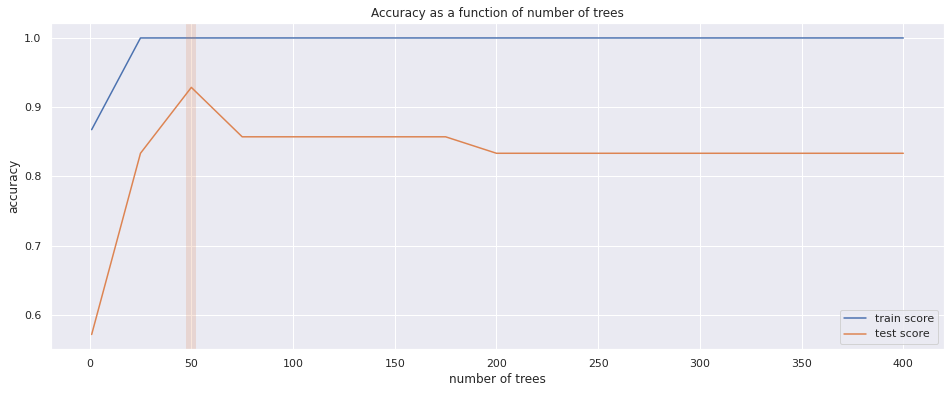

In [33]:
x = trees_range
sns.set(rc={'figure.figsize':(16, 6)})
plt.plot(x, acc_train, label='train score')
plt.plot(x, acc_test, label='test score')
plt.title("Accuracy as a function of number of trees")
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.axvline(x[np.argmax(acc_test)], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.legend()
plt.show();

Для наглядности построен график зависимости доли верных ответов от количества деревьев в случайном лесу. Видно, что accuracy случайного леса на тестовых данных уменьшается после 50 деревьев, в то время как на тренировочных данных достигла максимума. Можно сказать, что лес переобучился и способность алгоритма к обобщению упала. Вот список возможных причин которые могут вызвать переобучение:


*   В данных какие либо анамалии,либо шум.
*   Сильная мультиколлинеарность признаков
*   Большая глубина деревьев
*   Небольшой надбор данных (бутстрап дает не независимые наборы данных)



Now it's your turn to explore the various parameters of RandomForestClassifier and their influence on model quality.

# Homework part 2. Random Forest in action

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

_Note_: For tasks 1 to 5 please use your custom RandomForestClassifier if it is completed.

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

Так как GridSearchCV и RandomizedSearchCV используют кросс-валидацию, то решено не делить тренировочные, тестовые и валидационные данные. Будем тренировать и валидировать на тренировлочных данных, а тестировать на тестовых.

In [ ]:
# X_train, X_temp, y_train, y_temp = train_test_split(df.drop(columns='target'), df['target'], test_size=0.4, random_state=RANDOM_STATE)

In [ ]:
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=RANDOM_STATE)

parameters = {
              'n_estimators' : [*range(1, 100, 5)],
              'criterion' : ["gini", "entropy"],
              'max_depth' : [ 5, 10, 15, 20, 25, 30, 35, 40],
              }

gridsearch_forest = GridSearchCV(model, parameters, cv=5, verbose=0, n_jobs=-1, scoring='accuracy')
                       
gridsearch_forest.fit(X_train, y_train);

In [41]:
gridsearch_forest.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 36}

In [42]:
gridsearch_forest.best_score_

0.8260249554367203

In [43]:
gridsearch_forest.score(X_test, y_test)

0.8571428571428571

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [44]:
from sklearn.model_selection import RandomizedSearchCV

model_r = RandomForestClassifier()

max_depth = [int(x) for x in np.linspace(2, 50, num = 25)]
max_depth.append(None)
n_estimators = [*range(1, 100, 1)]

parameters = {
              'n_estimators' : n_estimators,
              'max_features' : ['auto', 'sqrt', 'log2'],
              'max_depth' : max_depth,
              }

randsearch_forest = RandomizedSearchCV(model_r, parameters, n_iter=100, cv=5, verbose=0, n_jobs=-1, scoring='accuracy', random_state=RANDOM_STATE)
                       
randsearch_forest.fit(X_train, y_train);

In [45]:
randsearch_forest.best_params_

{'max_depth': 34, 'max_features': 'auto', 'n_estimators': 53}

In [46]:
randsearch_forest.best_score_

0.8440285204991088

In [47]:
randsearch_forest.score(X_test, y_test)

0.8809523809523809

In [48]:
print(f"На тестовых данных RandomizedSearchCV дает accuracy {randsearch_forest.score(X_test, y_test)}")
print(f"На тестовых данных GridSearchCV дает accuracy {gridsearch_forest.score(X_test, y_test)}")

На тестовых данных RandomizedSearchCV дает accuracy 0.8809523809523809
На тестовых данных GridSearchCV дает accuracy 0.8571428571428571


В данном случае с помощью RandomizedSearchCV мы получили более высокий accuracy нежели с помощью GridSearchCV. Думаю с более подробной сеткой GridSearchCV, получилось бы точнее, но считает существенно дольше, чем RandomizedSearchCV.

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

GridSearchCV (Поиск по сетке) находит наилучшие параметры, путем перебора по заданной сетке гиперпараметров. Создается модель для каждой возможной комбинации гиперпараметров. Метод считает заданный критерий и на его основе максимизации/минимизации критерия выбирает лучшее сочетание гиперпараметров. Минус - вычислительные затраты при большой сетке значений гиперпараметров.

RandomizedSearchCV (Случайный поиск по сетке) случайным образом берет комбинации гиперпараметров и их оценивает. На основе полученных результатов происходит сужение области поиска. Случайный поиск по сетке полезнее простого поиска по сетке, когда гиперпараметров много, но тех которые сильно влияют на показания модели - мало.

В итоге, для нахождения лучшего сочетания  гиперпараметров наиболее походящим является поиск по сетке, правда при большом количестве гиперпараметров для перебора он займет много времени. Для быстрой подгонки гиперпараметров лучше подойдет случайный поиск по сетке, так как он работает быстрее обычного поиска по сетке.

Или еще вариант оценить значения гиперпараметров случайным поиском, а уточнить уже поиском по подробной сетке гиперпараметров.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [49]:
from sklearn.tree import DecisionTreeClassifier

PATH = '/content/gdrive/MyDrive/RS_school_course/7_trees_and_ensembles/data/train.csv'
df = pd.read_csv(PATH).set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
# Делим данные на тренировочные и проверочные

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_encode = df.copy()

X = df_encode.drop('Survived', axis=1)
y = df_encode['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

def cleaning(data_frame):

    # Средний возрас по полу
    data_frame['Sex'] = data_frame['Sex'].astype('category')
    mean_age_f = data_frame.loc[data_frame.Sex == 'female'].Age.mean()
    mean_age_m = data_frame.loc[data_frame.Sex == 'male'].Age.mean()

    # Заменяем средний пропущенный возраст средним по полу
    data_frame.loc[(data_frame["Age"].isna()) & (data_frame['Sex'] == 'female'), 'Age'] = mean_age_f
    data_frame.loc[(data_frame["Age"].isna()) & (data_frame['Sex'] == 'male'), 'Age'] = mean_age_m

    # Помечаем все пропуски в номерах кают.
    data_frame['Cabin'] = data_frame['Cabin'].fillna('empty')
    # Выделяем первую букву в номере каюты (не пригодилось)
    # data_frame['Deck'] = data_frame['Cabin'].map(lambda x: x[0] if x[0].isupper() else 'empty')

    # Просто делаем индикатор наличия каюты (не переделывал от получения первой буквы каюты)
    data_frame['Deck_1'] = data_frame['Cabin'].map(lambda x: 1 if x[0].isupper() else 0)

    # Проверяем четность последней цифры каюты (прочитал, что отвечает за левый или правый борт)
    data_frame['Side'] = data_frame['Cabin'].map(lambda x: int(x[-1])%2 if x[-1].isdigit() else -1)

    data_frame["Sex"] = le.fit_transform(data_frame["Sex"])
    data_frame["Embarked"] = le.fit_transform(data_frame["Embarked"])
    # data_frame["Deck"] = le.fit_transform(data_frame["Deck"])
    return data_frame

X_train = cleaning(X_train)
X_train = X_train.drop(['Name', 'Cabin', 'Ticket'], axis=1)

X_test = cleaning(X_test)
X_test = X_test.drop(['Name', 'Cabin', 'Ticket'], axis=1)

X_train.head(5)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck_1,Side
PassengerId,,,,,,,,,
132,3,1,20.0,0,0,7.050,2,0,-1
71,2,1,32.0,0,0,10.500,2,0,-1
782,1,0,17.0,1,0,57.000,2,1,0
509,3,1,28.0,0,0,22.525,2,0,-1
117,3,1,70.5,0,0,7.750,1,0,-1


In [51]:
mis_data = X_train.isnull().sum()
print(mis_data)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Deck_1      0
Side        0
dtype: int64


In [52]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

max_depth = [int(x) for x in np.linspace(2, 20, num = 12)]
max_depth.append(None)

parameters = {
              'max_features' : ['sqrt', 'log2'],
              'criterion' : ["gini", "entropy"],
              'max_depth' : max_depth,
              'splitter' : ['best', 'random'],
              }


rand_tree = RandomizedSearchCV(tree, parameters, cv=5, verbose=0, n_jobs=-1, scoring='accuracy', random_state=RANDOM_STATE)
                       
rand_tree.fit(X_train, y_train);

In [53]:
rand_tree.best_params_

{'criterion': 'gini',
 'max_depth': 13,
 'max_features': 'log2',
 'splitter': 'random'}

In [54]:
rand_tree.best_score_

0.8090318132571653

In [55]:
print(f"Точность полученых гиперпараметров с помощью случайного поиска по сетке : {rand_tree.score(X_test, y_test)}")

Точность полученых гиперпараметров с помощью случайного поиска по сетке : 0.770949720670391


In [56]:
tree_g = DecisionTreeClassifier(random_state=RANDOM_STATE)

max_depth = [int(x) for x in np.linspace(1, 30, num = 20)]

parameters = {
              'max_features' : ['log2', 'sqrt'],
              'max_depth' : max_depth,
              }

tree_grid = GridSearchCV(tree_g, parameters, cv=5, verbose=0, n_jobs=-1, scoring='accuracy')
                       
tree_grid.fit(X_train, y_train);

In [57]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 'log2'}

In [58]:
tree_grid.best_score_

0.807593814636068

In [69]:
print(f"Точность полученых гиперпараметров с помощью поиска по сетке : {tree_grid.score(X_test, y_test)}")

Точность полученых гиперпараметров с помощью поиска по сетке : 0.7932960893854749


In [62]:
print(f"На тестовых данных RandomizedSearchCV дает accuracy для Титаника {rand_tree.score(X_test, y_test)}")
print(f"На тестовых данных GridSearchCV дает accuracy для Титаника {tree_grid.score(X_test, y_test)}")

На тестовых данных RandomizedSearchCV дает accuracy для Титаника 0.770949720670391
На тестовых данных GridSearchCV дает accuracy для Титаника 0.7932960893854749


In [64]:
print(f"Параметры лучших моделей следующие :")
print(f"            RandomizedSearchCV :  {rand_tree.best_params_}")
print(f"            GridSearchCV :        {tree_grid.best_params_}")

Параметры лучших моделей следующие :
            RandomizedSearchCV :  {'splitter': 'random', 'max_features': 'log2', 'max_depth': 13, 'criterion': 'gini'}
            GridSearchCV :        {'max_depth': 7, 'max_features': 'log2'}


 Дерево для RandomizedSearchCV 


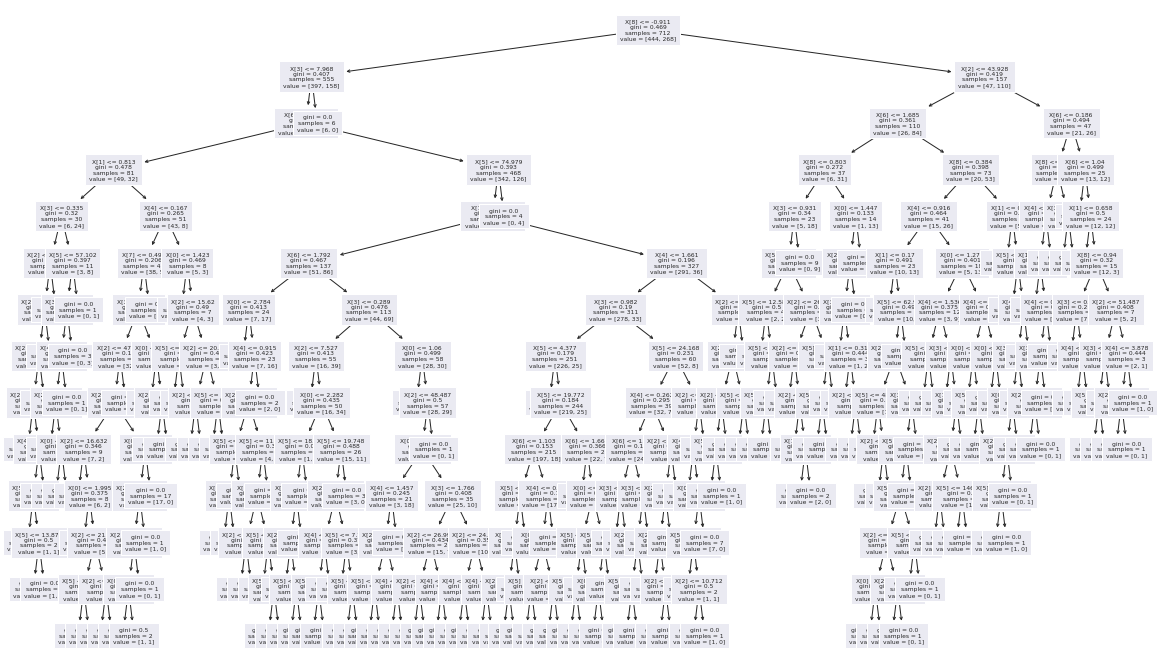

In [67]:
from sklearn import tree
print(' Дерево для RandomizedSearchCV ')
plt.figure(figsize=(20,12))
tree.plot_tree(rand_tree.best_estimator_, fontsize=6)

plt.show()

 Дерево для GridSearchCV 


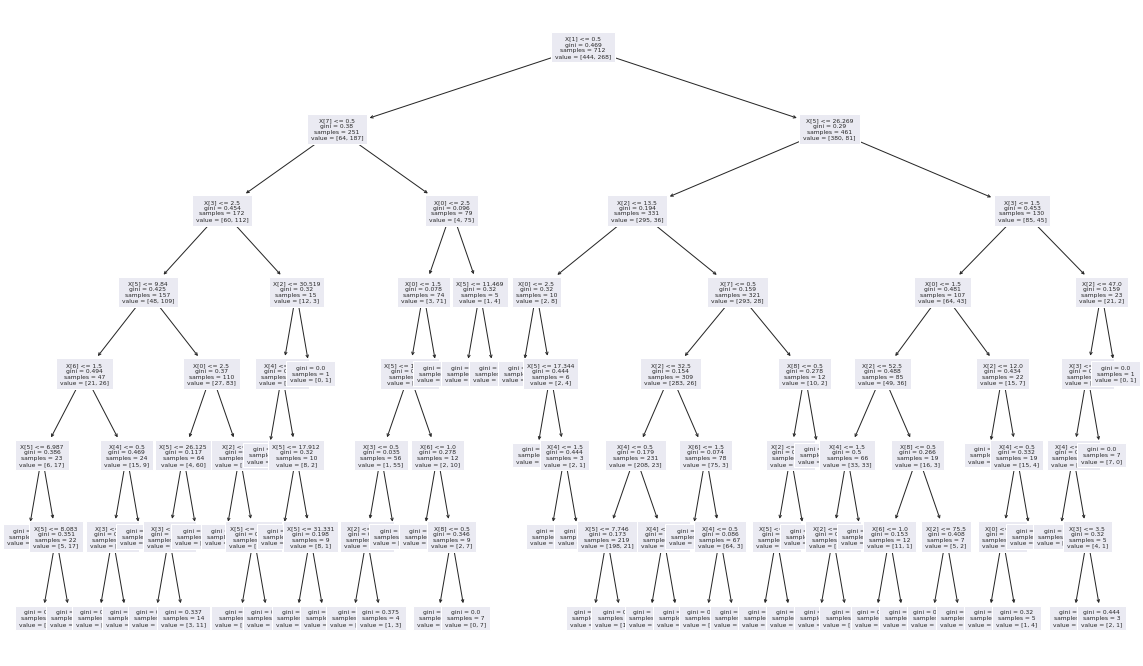

In [68]:
print(' Дерево для GridSearchCV ')
# test_tree = rand_tree.best_estimator_.fit(X_train, y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(tree_grid.best_estimator_, fontsize=6)

plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would they survive / die on the titanic?

После обработки данных, заполнения пропусков, а также создания новых признаков на основе существующих произведена классификация на основе decisionTreeClassifier. 


1.    С помощью ***RandomizedSearchCV*** получаем дерево со следующими параметрами:
splitter': 'random', 'max_features': 'log2', 'max_depth': 13, 'criterion': 'gini'.

   Доля верных ответов на тренировочных данных составляет - 0.809032, а на тестовых - 0.770949.
 На мой взгляд полученное дерево глубиной 13 достаточно разветвленное и глубокое для трудностей с использованием в ручной классификации выживших на Титанике.

2.   С помощью ***GridSearchCV*** получаем дерево со следующими параметрами:
'max_depth': 7, 'max_features': 'log2' и по умолчанию критерий Джини.

  Доля верных ответов на тренировочных данных составляет - 0.807594, а на тестовых - 0.793296. Полученое дерево имеет более простую структуру и глубину 7.
  Думаю для ручного использования человек будет испытывать проблемы для классификации с помощью этого дерева.

  Деревья и случайный лес дают хороший результат в классификации. Но для хорошей наглядности автоматическое построения дерева не обладаяет необходимой простотой и его достаточно тяжело интерпретировать, если конечно оно не маленькой глубины.

*Краткий вывод по работе*

  В данной домашей работе был изучен алгоритм классификации под названием "решающее дерево". Были построены графики и посчитаны необходимые метрики. Так же был опробован ансаблевый метод под названием "случайный лес" и два метода подбора гиперпараметров. "Решающее дерево" было применено к датасету Титаник
для определения выживаемости пассажиров. Получены 2  модели, посчитаны метрики и приведены параметры каждой модели.

Более подробные выводы написаны под соответсвующими пунктами.